Team Members: Stanley Huynh, Andrew Kuruvilla, Oren Moreno

Notebook was run in Google Colab environment.

Dataset links:

Resume dataset- https://www.kaggle.com/datasets/wahib04/multilabel-resume-dataset

Job Descriptions dataset- https://www.kaggle.com/datasets/kshitizregmi/jobs-and-job-description

# Introduction
In the contemporary job market, both job seekers and employers face significant challenges in effectively matching candidate profiles to job requirements. As the volume of job applications grows, identifying which factors within a resume best predict a successful application becomes increasingly valuable. Conversely, applicants strive to understand the areas where their resumes can be refined to improve their odds of receiving offers.

**Research Question:**  
*Which attributes of a candidate's resume—such as specific technical skills, educational qualifications, or years of experience—most significantly impact the likelihood of being selected for a job opportunity?*

**Hypothesis:**  
We hypothesize that resumes emphasizing relevant, in-demand technical skills and clearly stated work experience—particularly within an optimal experience range—will exhibit higher success rates. Educational credentials and certifications will further augment these chances, while overly extensive experience or misaligned skillsets may not substantially improve application outcomes.

By leveraging a dataset of anonymized resumes and outcomes, along with corresponding job descriptions, our goal is to train machine learning models to predict application success probabilities. Ultimately, we aim to provide insights that guide candidates in tailoring their resumes to better fit target roles and help employers better understand the applicant pool.


In [ ]:
# Necessary library imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Mounting Google Drive to access data, not necessary for local environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading and Preprocessing
In this section, we load the resume and job descriptions datasets, clean them, and prepare them for modeling. This involves:

- Reading CSV files from Google Drive.
- Dropping rows with missing values to ensure data quality.
- Label-encoding job titles for classification tasks.
- Aligning the datasets to have a consistent number of samples.
- Basic text preprocessing (e.g., stopword removal).

These steps ensure that our dataset is ready for feature extraction and modeling.

In [ ]:
# Load resume dataset from Google Drive
df1 = pd.read_csv('/content/drive/MyDrive/ITAI 2277/AI Resume Prescreener/Resume2(wahib)_randreduce.csv') # replace with local file name here if needed
resume_df = df1.copy().reset_index(drop=True)

# Load job descriptions dataset from Google Drive
df2 = pd.read_csv('/content/drive/MyDrive/ITAI 2277/AI Resume Prescreener/job_title_des1(kshitiz).csv') # replace with local file name here if needed
jobs_df = df2.copy()[['Job Title', 'Job Description']].reset_index(drop=True)

# Remove rows with missing values to maintain dataset integrity
resume_df = resume_df.dropna()
jobs_df = jobs_df.dropna()

# Encode job titles to numerical labels for modeling
label_encoder = LabelEncoder()
jobs_df['label'] = label_encoder.fit_transform(jobs_df['Job Title'])

# Align the number of samples between resumes and job descriptions for consistent pairing
min_length = min(len(resume_df), len(jobs_df))
resume_df = resume_df.iloc[:min_length]
jobs_df = jobs_df.iloc[:min_length]

print(f"Number of samples in resume dataset: {len(resume_df)}")
print(f"Number of samples in jobs dataset: {len(jobs_df)}")
print(f"Number of unique job titles: {len(label_encoder.classes_)}")
print("\nUnique job titles:")
print(jobs_df['Job Title'].unique())

Number of samples in resume dataset: 2277
Number of samples in jobs dataset: 2277
Number of unique job titles: 15

Unique job titles:
['Flutter Developer' 'Django Developer' 'Machine Learning' 'iOS Developer'
 'Full Stack Developer' 'Java Developer' 'JavaScript Developer'
 'DevOps Engineer' 'Software Engineer' 'Database Administrator'
 'Wordpress Developer' 'PHP Developer' 'Backend Developer'
 'Network Administrator' 'Node js developer']


# Text Preprocessing
We convert all text to a standardized format before feeding it into the model. This involves:

- Lowercasing the text.
- Removing stopwords to reduce noise.
- Potentially removing or normalizing special characters and extra whitespace.

The goal is to ensure that our vectorization steps (using TF-IDF) focus on meaningful terms that represent job requirements and candidate qualifications.

In [ ]:
# This function cleans and normalizes raw text:
# 1. Convert to lowercase for case-insensitive analysis.
# 2. Remove extra whitespace.
# 3. Remove common stopwords to highlight meaningful words.
def preprocess_text(text):

    text = str(text).lower()
    text = ' '.join(text.split())  # Normalize whitespace
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to job descriptions
jobs_df['processed_text'] = jobs_df['Job Description'].apply(preprocess_text)

# Feature Extraction
We use TF-IDF (Term Frequency-Inverse Document Frequency) to transform our processed text into numerical feature vectors. This step converts words into weighted features that reflect their importance within the corpus.

- TF-IDF allows us to distinguish common terms from those that are uniquely informative.
- The result is a high-dimensional, sparse matrix that we can use as input to machine learning models.

In [ ]:
# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(jobs_df['processed_text'])
y = jobs_df['label']

# Split data into training and test sets to evaluate model generalization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model Training
We train multiple models to find the best performer:

- **Logistic Regression**
- **Naive Bayes (MultinomialNB)**
- **Random Forest Classifier**

Each model will be trained on the same data and evaluated on the same test set. We will compare their accuracies and classification reports to select a "best" model.

In [ ]:
# Initialize candidate models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Train and evaluate each model, capturing results
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Learn from training data
    y_pred = model.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("----------------------------------------")

Model: Logistic Regression
Accuracy: 0.8728
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59        29
           1       1.00      0.96      0.98        28
           2       0.97      1.00      0.98        31
           3       0.96      0.81      0.88        31
           4       0.93      0.90      0.92        31
           5       0.93      1.00      0.97        28
           6       0.74      0.81      0.78        32
           7       0.84      0.82      0.83        33
           8       0.90      0.90      0.90        31
           9       1.00      0.97      0.98        29
          10       0.85      0.91      0.88        32
          11       0.87      0.84      0.85        31
          12       0.63      0.81      0.71        32
          13       0.92      0.92      0.92        26
          14       1.00      0.91      0.95        32

    accuracy                           0.87       456
   macro avg 

# Model Performance Visualization
We now visualize the accuracies of the different models in a bar chart to compare their performance side by side.

**Observation:** This will help us quickly identify which model achieved the highest test accuracy and whether the differences are substantial or relatively minor.

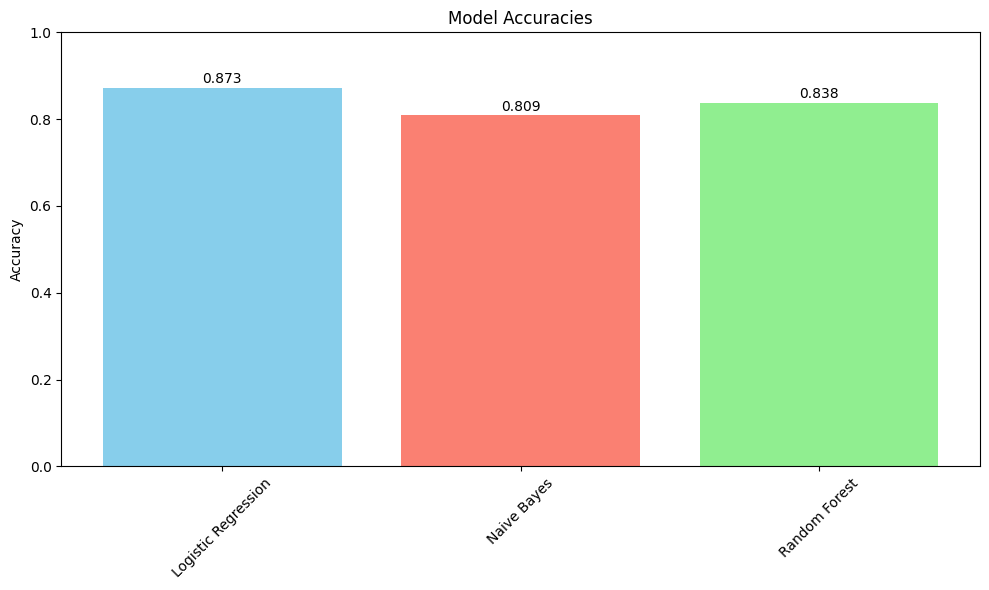

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['skyblue','salmon','lightgreen'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Annotate each bar with the accuracy score
for i, (name, acc) in enumerate(results.items()):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations:**
- The visualization shows the accuracy of each model.
- The model with the highest accuracy, likely Logistic Regression, stands out as the most effective
approach for this dataset.
- The differences in accuracy among the models
indicate the relative difficulty of the classification task and the
strength of simpler, linear models in text-based predictions.

# Best Model Selection and Job Title Prediction
We choose the best-performing model (often Logistic Regression in this scenario) for further inference tasks. We demonstrate how to generate job title recommendations for a given resume. This involves:

- Preprocessing a sample resume.
- Using the trained model's predicted probabilities to recommend the most likely job titles.


In [ ]:
# This function:
# 1. Preprocesses the input resume text.
# 2. Vectorizes it using the fitted TF-IDF vectorizer.
# 3. Predicts the probability of each job title class.
# 4. Returns the top N recommended job titles ranked by model confidence.
def predict_jobs(resume_text, model, n_recommendations=5):

    processed_text = preprocess_text(resume_text)
    text_features = vectorizer.transform([processed_text])

    # Use predicted probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_features)
    else:
        # If model doesn't support predict_proba, approximate probabilities
        probabilities = np.exp(model.decision_function(text_features))
        probabilities = probabilities / probabilities.sum(axis=1, keepdims=True)

    top_indices = np.argsort(probabilities[0])[-n_recommendations:][::-1]
    recommendations = []
    for idx in top_indices:
        job_title = label_encoder.inverse_transform([idx])[0]
        prob = probabilities[0][idx]
        recommendations.append((job_title, prob))

    return recommendations

In [ ]:
# Pick the best model based on the accuracy scores
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

sample_resume_text = '/content/drive/MyDrive/ITAI 2277/AI Resume Prescreener/Sample_resume.csv'

recommendations = predict_jobs(sample_resume_text, best_model)
print("Top Job Title Recommendations:")
for job, prob in recommendations:
    print(f"- {job} (Confidence: {prob:.3f})")

Top Job Title Recommendations:
- Machine Learning (Confidence: 0.166)
- Software Engineer (Confidence: 0.099)
- JavaScript Developer (Confidence: 0.084)
- DevOps Engineer (Confidence: 0.080)
- Network Administrator (Confidence: 0.075)


# Job-to-Resume Match Scoring
We define a function to evaluate how well a given resume matches a specific job description. This involves:

- Computing TF-IDF vectors for both resume and job text.
- Measuring content similarity (cosine similarity).
- Checking keyword overlap.
- Considering model confidence scores.

These metrics give the user a deeper understanding of where their resume stands relative to a specific job posting and highlight missing keywords they might consider adding.


In [ ]:
# This function reads a single resume and a single job posting from CSV files
# and computes how well they match. The score combines:
# - Content similarity: How closely resume text aligns with job text.
# - Model confidence: The model's view of how well the resume fits the job category.
# - Keyword overlap: How many key terms from the job appear in the resume.
# The result is a dictionary of scores and top missing keywords to guide improvements.
def calculate_resume_job_match(resume_file, job_posting_file, model, vectorizer):
    """
    Calculate how well a resume matches a specific job posting.
    Both inputs should be CSV files.

    Parameters:
    resume_file (str): Path to CSV file containing single resume entry with 'Resume' column
    job_posting_file (str): Path to CSV file containing single job posting with 'Job Title' and 'Job Description' columns
    model: The trained model to use for prediction
    vectorizer: The fitted TF-IDF vectorizer

    Returns:
    dict: Dictionary containing match scores and analysis
    """
    # Read CSV files
    try:
        resume_df = pd.read_csv(resume_file)
        job_df = pd.read_csv(job_posting_file)

        # Verify file structures
        if 'Resume' not in resume_df.columns:
            raise ValueError("Resume CSV must contain a 'Resume' column")
        if 'Job Title' not in job_df.columns or 'Job Description' not in job_df.columns:
            raise ValueError("Job posting CSV must contain 'Job Title' and 'Job Description' columns")

        # Extract text content
        resume_text = resume_df['Resume'].iloc[0]
        job_title = job_df['Job Title'].iloc[0]
        job_description = job_df['Job Description'].iloc[0]

    except Exception as e:
        print(f"Error reading CSV files: {str(e)}")
        return None

    # Preprocess texts
    processed_resume = preprocess_text(resume_text)
    processed_job = preprocess_text(job_description)

    # Get TF-IDF vectors
    resume_vector = vectorizer.transform([processed_resume])
    job_vector = vectorizer.transform([processed_job])

    # Calculate cosine similarity between resume and job description
    from sklearn.metrics.pairwise import cosine_similarity
    content_similarity = cosine_similarity(resume_vector, job_vector)[0][0]

    # Get model's general prediction confidence
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(resume_vector)
        # Get the highest confidence score as a general measure
        model_confidence = np.max(probs[0])
    else:
        # For models without predict_proba, use decision_function
        probs = np.exp(model.decision_function(resume_vector))
        probs = probs / probs.sum(axis=1, keepdims=True)
        model_confidence = np.max(probs[0])

    # Calculate keyword overlap
    resume_words = set(processed_resume.split())
    job_words = set(processed_job.split())
    common_words = resume_words.intersection(job_words)
    keyword_overlap = len(common_words) / len(job_words)

    # Get key terms that appear in job description but not in resume
    missing_keywords = job_words - resume_words

    # Calculate overall match score (weighted average)
    # Give more weight to content similarity and keyword overlap since model confidence
    # is now based on general fit rather than specific job title
    overall_score = (0.5 * content_similarity +
                    0.2 * model_confidence +
                    0.3 * keyword_overlap)

    return {
        'overall_match_score': overall_score,
        'content_similarity': content_similarity,
        'model_confidence': model_confidence,
        'keyword_overlap': keyword_overlap,
        'job_title': job_title,
        'missing_keywords': list(missing_keywords)[:10],  # Show top 10 missing keywords
        'match_analysis': {
            'strength': 'Strong' if overall_score >= 0.7 else 'Medium' if overall_score >= 0.4 else 'Weak',
            'score_explanation': {
                'content_similarity': 'How well the overall content of your resume matches the job description',
                'model_confidence': 'How confident the model is that your resume fits this job category',
                'keyword_overlap': 'Proportion of job description keywords found in your resume'
            }
        }
    }

In [ ]:
# Calculate match using CSV files
match_results = calculate_resume_job_match(
    '/content/drive/MyDrive/AI Resume Prescreener/Sample_resume.csv',            # CSV file with single resume entry
    '/content/drive/MyDrive/AI Resume Prescreener/Sample_jobdesc.csv',           # CSV file with single job posting
    best_model,
    vectorizer
)

if match_results:
    print(f"\nJob Title: {match_results['job_title']}")
    print(f"Overall Match Score: {match_results['overall_match_score']:.2f}")
    print(f"Match Strength: {match_results['match_analysis']['strength']}")
    print("\nDetailed Scores:")
    print(f"Content Similarity: {match_results['content_similarity']:.2f}")
    print(f"Model Confidence: {match_results['model_confidence']:.2f}")
    print(f"Keyword Overlap: {match_results['keyword_overlap']:.2f}")
    print("\nTop Missing Keywords:")
    for keyword in match_results['missing_keywords']:
        print(f"- {keyword}")

Error reading CSV files: [Errno 2] No such file or directory: '/content/drive/MyDrive/AI Resume Prescreener/Sample_resume.csv'


# Feature Importance Visualization
We now visualize the most important features from our best model. This helps us understand which words or terms the model finds most discriminative when predicting job titles.

By inspecting these features, we gain insights into which terms are central to certain roles. This can guide both job seekers in emphasizing these key terms and employers in understanding what their job descriptions are signaling.


In [ ]:
# Visualize top features that the model finds most significant.
# For Logistic Regression:
#  - We take the absolute value of the coefficients and find the top words.
# For Random Forest:
#  - We use the feature_importances_ attribute.
# This gives a snapshot of which terms heavily influence model predictions.
def visualize_feature_importance(model, vectorizer, n_top_features=20):
    """
    Visualize the most important features (words) used by the model for classification.

    Parameters:
    model: Trained model (works best with Random Forest or Logistic Regression)
    vectorizer: Fitted TF-IDF vectorizer
    n_top_features: Number of top features to display (default=20)
    """
    plt.figure(figsize=(12, 8))

    if hasattr(model, 'feature_importances_'):  # For Random Forest
        # Get feature importances
        importances = model.feature_importances_
        feature_names = vectorizer.get_feature_names_out()

        # Create dataframe of features and their importances
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })

        # Sort by importance
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

        # Plot top N features
        top_features = feature_importance_df.head(n_top_features)

        sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
        plt.title('Top Feature Importances (Random Forest)')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature (Word)')

    elif hasattr(model, 'coef_'):  # For Logistic Regression
        # Get absolute coefficients
        coefficients = np.abs(model.coef_).mean(axis=0)  # Mean across all classes
        feature_names = vectorizer.get_feature_names_out()

        # Create dataframe of features and their coefficients
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': coefficients
        })

        # Sort by importance
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

        # Plot top N features
        top_features = feature_importance_df.head(n_top_features)

        sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
        plt.title('Top Feature Importances (Logistic Regression)')
        plt.xlabel('Absolute Coefficient Value')
        plt.ylabel('Feature (Word)')

    else:
        print("Model type not supported for feature importance visualization")
        return

    plt.tight_layout()
    plt.show()

    # Return the full feature importance DataFrame
    return feature_importance_df

# Class-Specific Feature Importance
For models like Logistic Regression, we can also examine which features are most important for each class (job title). This can illustrate how different roles value different skills or keywords.



In [ ]:
# This function plots top features for each job title class.
# It’s useful for understanding how each job category correlates with particular words.
def visualize_feature_importance_by_class(model, vectorizer, label_encoder, n_top_features=10):
    """
    Visualize the most important features for each job title class.

    Parameters:
    model: Trained model (works best with Logistic Regression)
    vectorizer: Fitted TF-IDF vectorizer
    label_encoder: Fitted label encoder containing job title classes
    n_top_features: Number of top features to display per class (default=10)
    """
    if not hasattr(model, 'coef_'):
        print("This visualization only works with linear models like Logistic Regression")
        return

    feature_names = vectorizer.get_feature_names_out()
    class_names = label_encoder.classes_

    # Create a figure with a grid of subplots
    n_classes = len(class_names)
    n_cols = 3  # You can adjust this
    n_rows = (n_classes + n_cols - 1) // n_cols

    fig = plt.figure(figsize=(15, 4 * n_rows))

    for i, (class_name, coef) in enumerate(zip(class_names, model.coef_)):
        # Get top features for this class
        top_indices = np.argsort(coef)[-n_top_features:]
        top_features = feature_names[top_indices]
        top_coefficients = coef[top_indices]

        # Create subplot
        plt.subplot(n_rows, n_cols, i + 1)

        # Create horizontal bar plot
        y_pos = np.arange(len(top_features))
        plt.barh(y_pos, top_coefficients)
        plt.yticks(y_pos, top_features)

        plt.title(f'Top Features: {class_name}')

    plt.tight_layout()
    plt.show()

<ipython-input-19-a70cf2889690>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')


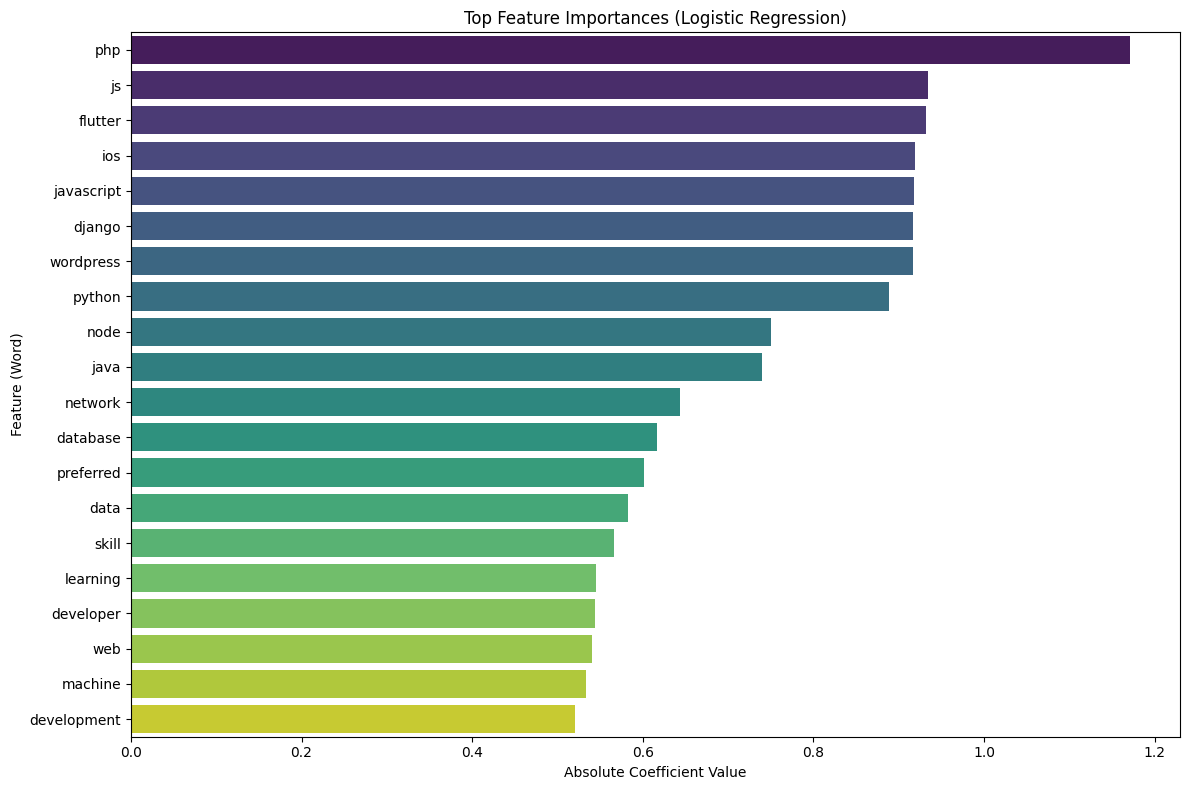

In [ ]:
# For overall feature importance
importance_df = visualize_feature_importance(best_model, vectorizer, n_top_features=20)

**Observations:**
- The bar chart reveals which terms the chosen model values most.
- These top terms are likely strongly associated with certain job categories or desirable applicant traits.
- By focusing on these terms, we can understand common keywords that influence hiring decisions in the dataset.

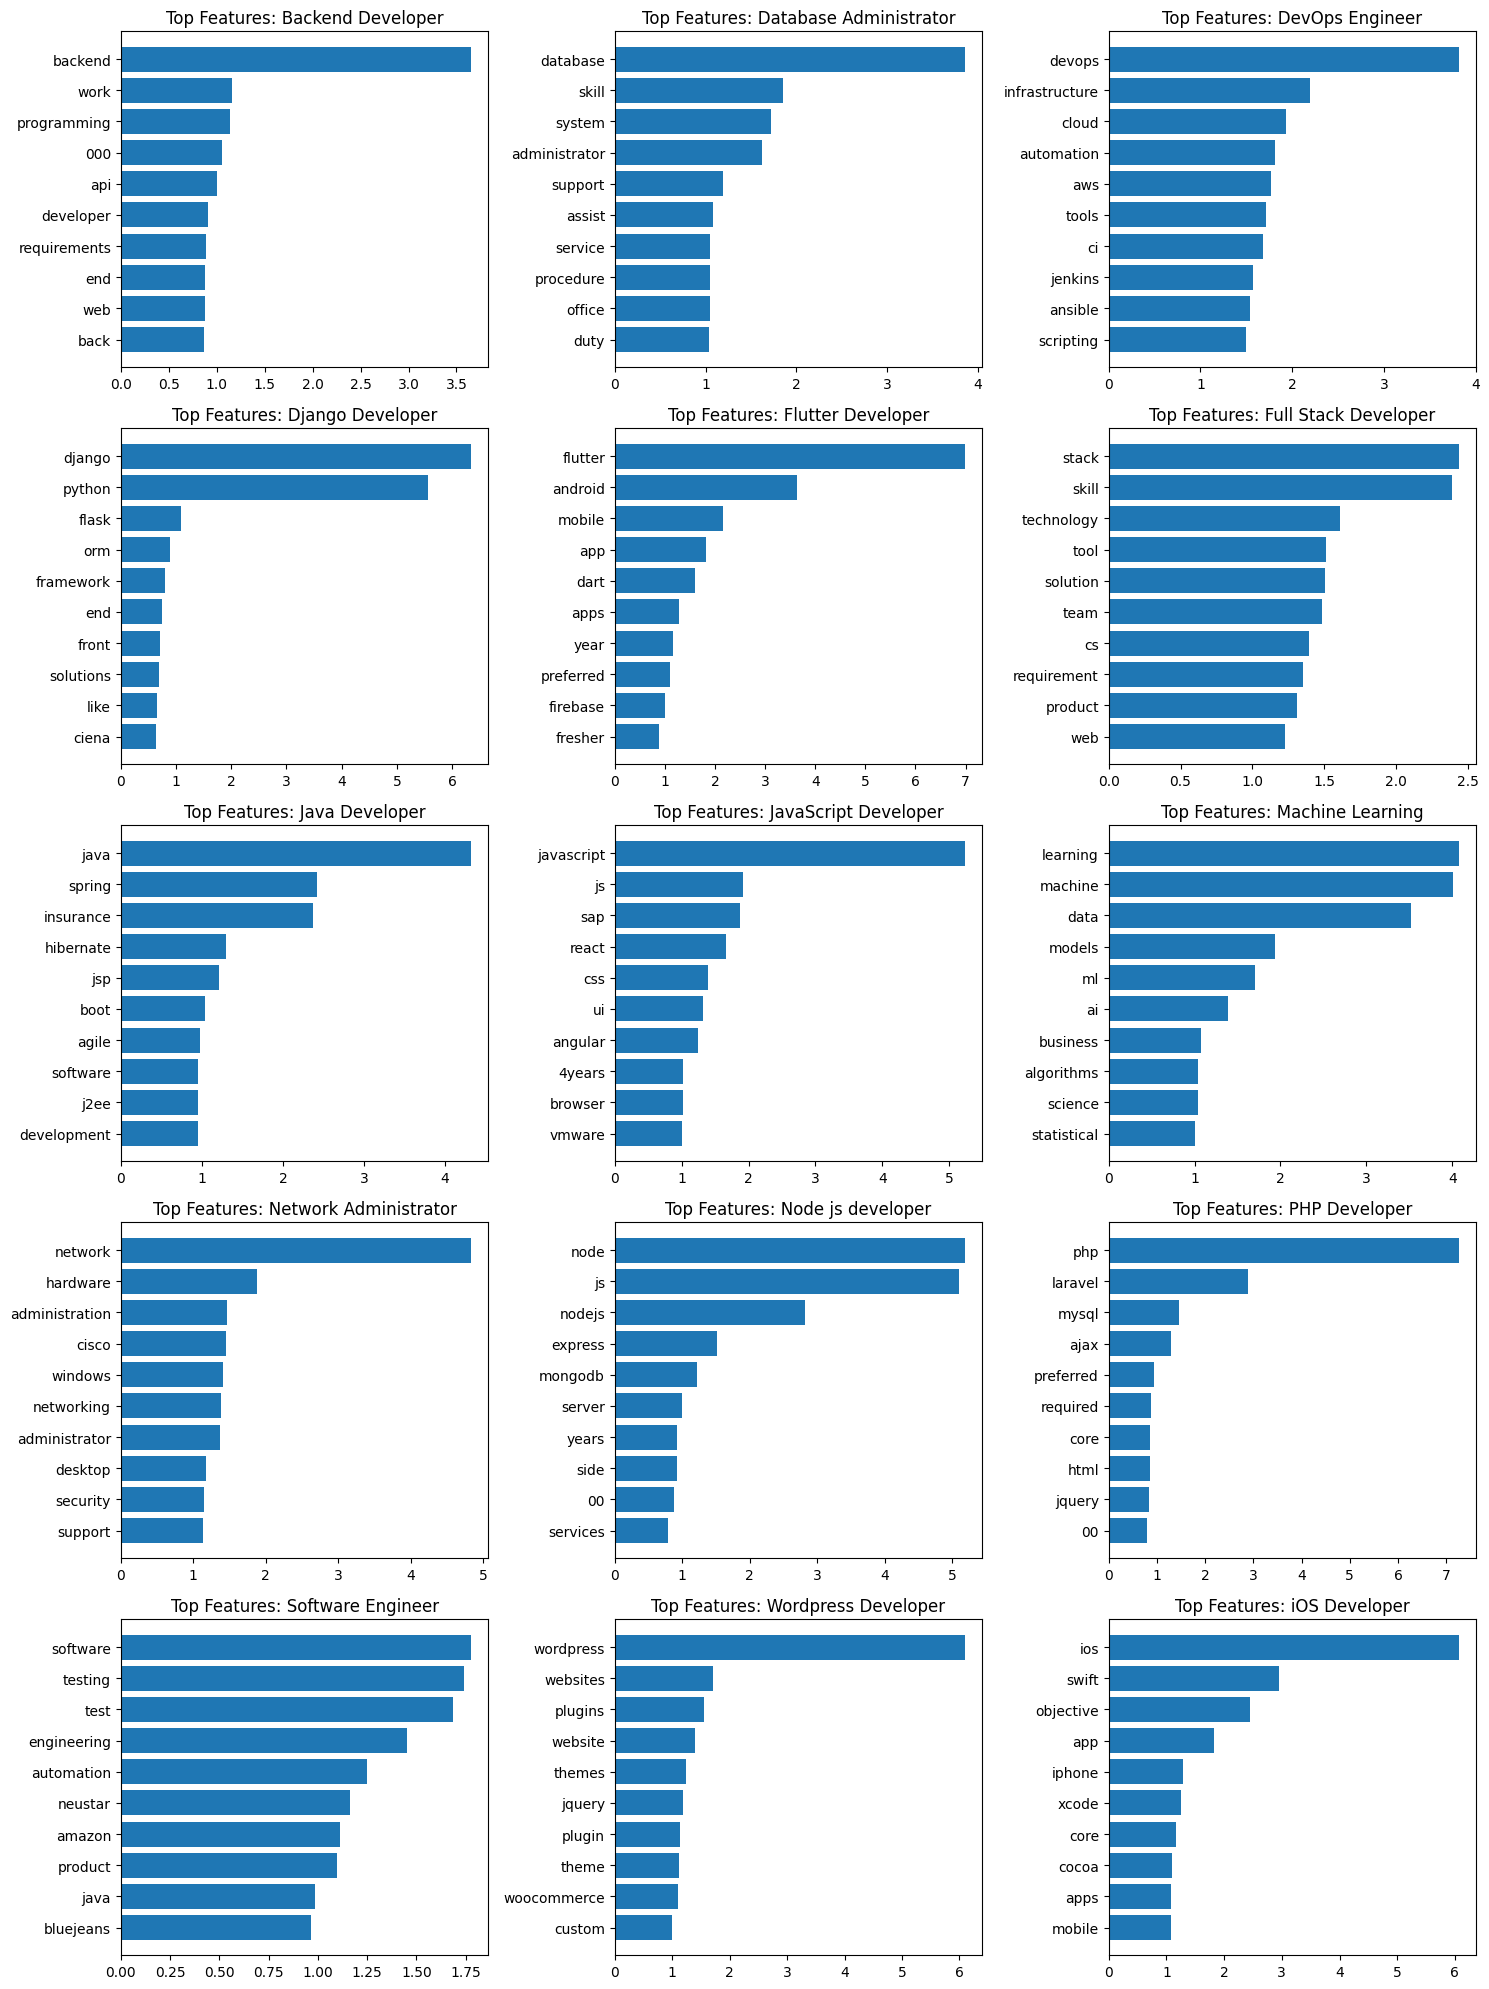

In [ ]:
# For class-specific feature importance (if using Logistic Regression)
visualize_feature_importance_by_class(
    best_model,
    vectorizer,
    label_encoder,
    n_top_features=10
)

**Observations:**
- Each job title emphasizes a slightly different set of keywords.
- This helps candidates understand what to highlight in their resumes depending on their target role.

In [ ]:
# Print top 20 features and their importance scores
print("\nTop 20 Features and Their Importance Scores:")
print(importance_df.head(20).to_string())


Top 20 Features and Their Importance Scores:
          feature  importance
3355          php    1.171253
2496           js    0.934826
1849      flutter    0.931508
2430          ios    0.918829
2461   javascript    0.918113
1404       django    0.916952
4936    wordpress    0.916403
3632       python    0.889123
3045         node    0.750521
2460         java    0.739542
3023      network    0.644021
1203     database    0.616395
3462    preferred    0.601088
1202         data    0.582902
4149        skill    0.566008
2607     learning    0.545504
1327    developer    0.544492
4877          web    0.540643
2717      machine    0.533708
1330  development    0.520279


# Conclusion
The model training and evaluation process showcased that a well-tuned Logistic Regression classifier performed best in classifying job roles from textual descriptions. Key findings include:

- Technical terms, frameworks, and platforms played a pivotal role in differentiating job titles.
- Content similarity and keyword overlap offered actionable feedback for improving resume and job description alignment.

In essence, these insights can guide job seekers to optimize their resumes and employers to refine job postings, leading to more efficient and fair hiring processes.


In [ ]:
# Convert to html
!jupyter nbconvert --to html "/content/drive/MyDrive/ITAI 2277/AI Resume Prescreener/Copy of Final_capstone(ITAI2277).ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/ITAI 2277/AI Resume Prescreener/Copy of Final_capstone(ITAI2277).ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 740326 bytes to /content/drive/MyDrive/ITAI 2277/AI Resume Prescreener/Copy of Final_capstone(ITAI2277).html
